In [19]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import pandas
from skimage.color import rgb2gray
from scipy import signal as sig
from scipy.ndimage import gaussian_filter

In [20]:
def imshow(*args, title=None, figsize=20, to_rgb=True, fontsize=12):
    if isinstance(figsize, int):
        figsize = (figsize, figsize)
    images = args[0] if type(args[0]) is list else list(args)
    if to_rgb:
        images = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB), images))
    if title is not None:
        assert len(title) == len(images), "Please provide a title for each image."
    plt.figure(figsize=figsize)
    for i in range(1, len(images)+1):
        plt.subplot(len(images), 1, i)
        if title is not None:
            plt.title(title[i-1], fontsize=fontsize)
        if images[i-1].ndim == 2:
            plt.imshow(images[i-1], cmap='gray')
        else:
            plt.imshow(images[i-1])
        plt.axis('off')

In [21]:
def normalize(a):
    if isinstance(a, list):
        return list(map(normalize, a))
    if isinstance(a, tuple):
        return tuple(normalize(list(a)))
    values = (((a - a.min()) / (a.max() - a.min())) * 255)
    values = values.astype('uint8')
    return values

# 7.1. Harris Corner Detector

In [55]:
def harris_corners(img, window_size):
    smooth = cv2.GaussianBlur(img,(3,3),0)
    gray = cv2.cvtColor(smooth, cv2.COLOR_BGR2GRAY)
    grad_x =  cv2.Sobel(gray,-1,1,0,ksize = 3)
    grad_y =  cv2.Sobel(gray,-1,0,1,ksize = 3)

    h,w = grad_x.shape
    corners = np.zeros((h,w), dtype = np.float64)
    grad_x = grad_x.astype(np.float64)
    grad_y = grad_y.astype(np.float64)

    grad_xx = grad_x**2
    grad_xx = cv2.GaussianBlur(grad_xx,(3,3),0.5)
    grad_yy = grad_y**2
    grad_yy = cv2.GaussianBlur(grad_yy,(3,3),0.5)
    grad_xy = grad_x *grad_y
    grad_xy = cv2.GaussianBlur(grad_xy, (3,3), 0.5)



    offset = int(window_size/2)
    for i in range(offset, h-offset):
        for j in range(offset, w-offset):
            temp1 = grad_xx[i-offset:i+offset+1, j-offset:j+offset+1]
            temp2 = grad_yy[i-offset:i+offset+1, j-offset:j+offset+1]
            temp3 = grad_xy[i-offset:i+offset+1, j-offset:j+offset+1]
            a = np.sum(temp1)
            b = np.sum(temp2)
            c= np.sum(temp3)
            det  = a*b - (c*c)
            trace = a+b
            R = det - 0.04*(trace**2)
            corners[i,j] = R

    return corners

In [56]:
def draw_corners(corner, img, scale, marker_size):
  y, x = np.nonzero(corner > 0.4 * np.max(corner))
  for i in range(len(x)):
      x1 = int(x[i]); y1 = int(y[i])
      cv2.circle(img, (x1,y1), marker_size ,(0,0,255),-1)

  imshow(img,title=[f'scale = {scale}'], figsize=10)  

In [57]:
def corner_detector(image, i, w_size):
  img1 = image.copy()
  x , y ,channal= img1.shape
  
  img  = cv2.resize(img1, (int(y * i),int(x * i)))
  c = harris_corners(img, w_size)
  draw_corners(c, img, i, int(i*3))

## 7.1.1. Extract interest points using the Harris Corner detector that you implemented

In [60]:
harris = cv2.imread('/content/sample_data/harris.JPG', cv2.IMREAD_UNCHANGED)

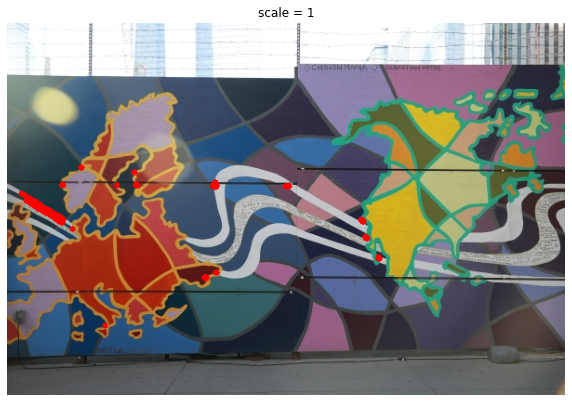

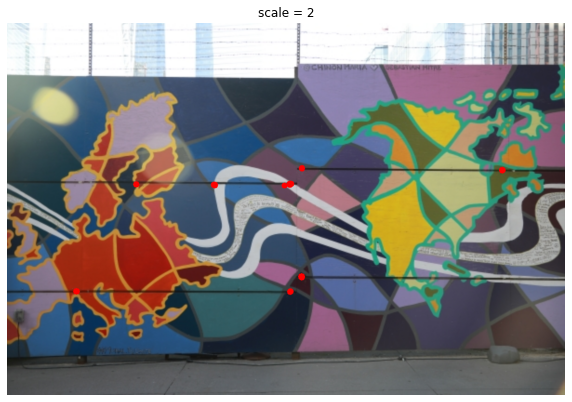

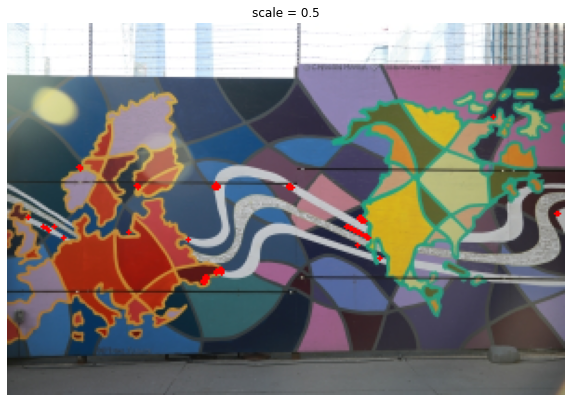

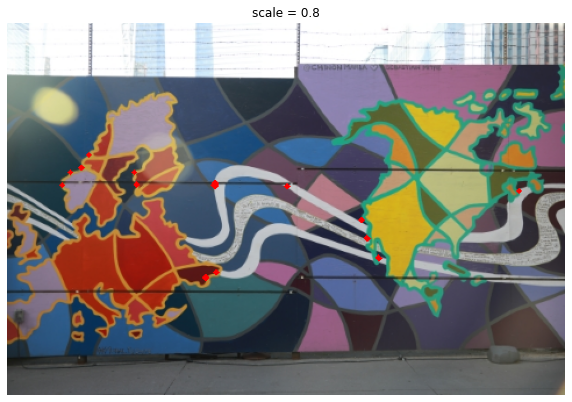

In [62]:
corner_detector(harris, 1, 5)
corner_detector(harris, 2, 5)
corner_detector(harris, 0.5, 3)
corner_detector(harris, 0.8, 3)

# 7.2. Scene stitching with SIFT/SURF features

## 7.2.1. Use the OpenCV, Python, and MATLAB implementation of the SIFT or SURF operator to find interest points and establish correspondences between the image

In [63]:
sl = cv2.imread('/content/sample_data/sl.jpg', cv2.IMREAD_UNCHANGED)
sm = cv2.imread('/content/sample_data/sm.jpg', cv2.IMREAD_UNCHANGED)
sr = cv2.imread('/content/sample_data/sr.jpg', cv2.IMREAD_UNCHANGED)

In [67]:
def sift(img1, img2, img3):
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
  keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
  keypoints3, descriptors3 = sift.detectAndCompute(img3, None)

  bf = cv2.BFMatcher()
  matches12 = bf.knnMatch(descriptors1, descriptors2, k=2)
  matches13 = bf.knnMatch(descriptors1, descriptors3, k=2)
  matches23 = bf.knnMatch(descriptors2, descriptors3, k=2)

  good_matches12 = []
  for m, n in matches12:
      if m.distance < 0.75 * n.distance:
          good_matches12.append(m)
          
  good_matches13 = []
  for m, n in matches13:
      if m.distance < 0.75 * n.distance:
          good_matches13.append(m)

  good_matches23 = []
  for m, n in matches23:
      if m.distance < 0.75 * n.distance:
          good_matches23.append(m)

  img_matches12 = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches12, None)
  img_matches13 = cv2.drawMatches(img1, keypoints1, img3, keypoints3, good_matches13, None)
  img_matches23 = cv2.drawMatches(img2, keypoints2, img3, keypoints3, good_matches23, None)

  return img_matches12, img_matches13, img_matches23

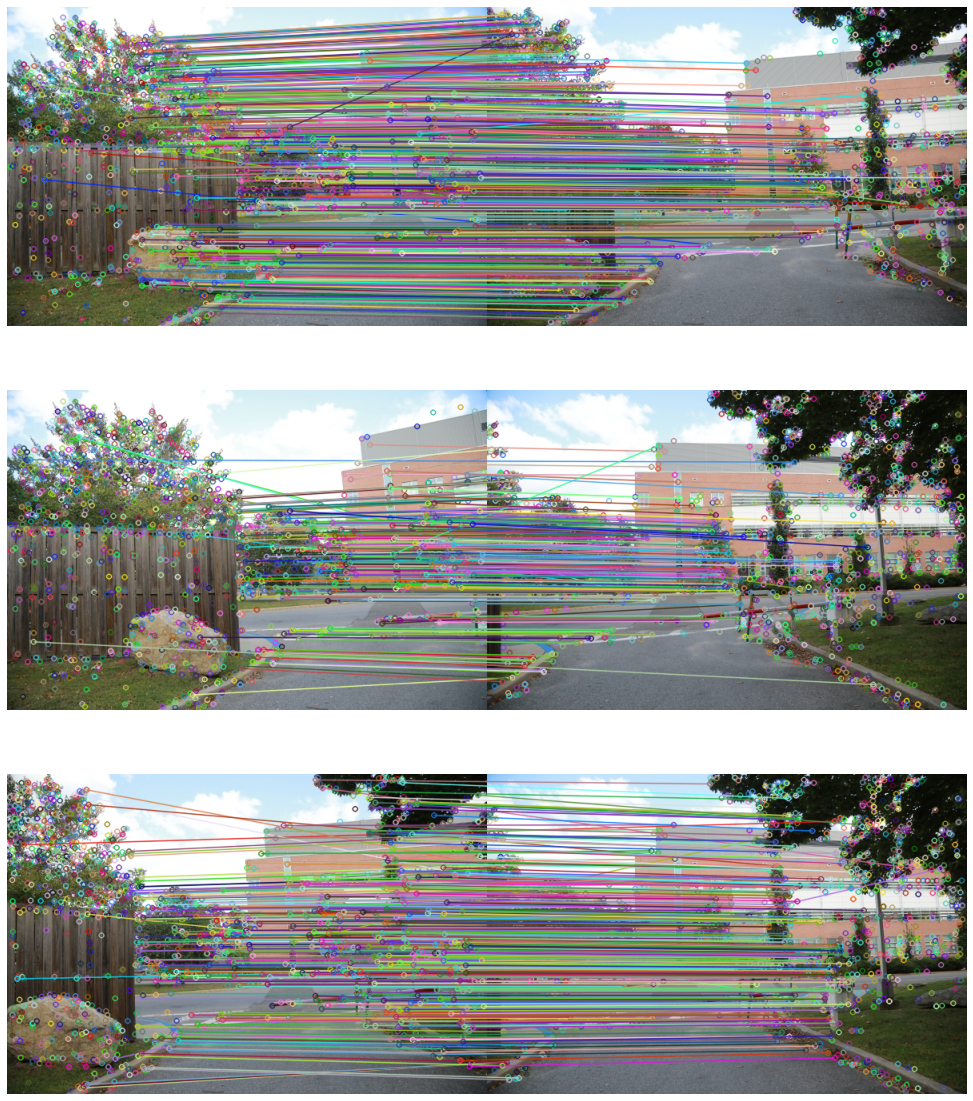

In [70]:
matches = sift(sl,sm,sr)
imshow(matches[0],matches[1], matches[2])